Brian2 cannot be found. It will not be possible to run simulation with Brian2.
INFO: Starting up spiking-FT:
- Configuration file: ../config/experiment_special_cases.json
- Simulation time: 256
- Time step: 1
- FT mode: fft
- Framework: radix4loihi
- Test performance: False
INFO: Loading data
INFO: Data loaded:
- Source: TI_sensor_special
- Nº frames: 1
- Nº chirps: 4
- Nº samples: 64
- Nº antennas: 1
INFO: Encoding data to spikes
INFO: Initializing SNN simulation
DEBUG: Creating Compartments ...
DEBUG: Creating CompartmentPrototypes of Layer 0 ...
DEBUG: Creating CompartmentPrototypes of Layer 1 ...
DEBUG: Creating CompartmentPrototypes of Layer 2 ...
DEBUG: Done.
DEBUG: Creating ConnectionPrototype ...
DEBUG: Creating auxillary neurons ...
DEBUG: Clock neuron connected to layer 0.
DEBUG: Reset neuron connected to layer 0.
DEBUG: Clock neuron connected to layer 1.
DEBUG: Reset neuron connected to layer 1.
DEBUG: Clock neuron connected to layer 2.
DEBUG: Reset neuron connected to layer

INFO:DRV:  Connecting to 127.0.0.1:40565
INFO:DRV:      Host server up..............Done 0.74s
INFO:DRV:      Encoding axons/synapses.....Done 0.12s
INFO:DRV:      Compiling Embedded snips....Done 0.11s
INFO:DRV:      Compiling MPDS Registers....Done 0.28ms
INFO:DRV:      Booting up..................Done 2.19s
INFO:DRV:      Encoding probes.............Done 7.14ms
INFO:DRV:      Transferring probes.........Done 0.02s
INFO:DRV:      Configuring registers.......Done 0.31s
INFO:DRV:      Transferring spikes.........Done 2.00ms
INFO:DRV:      Executing...................Done 40.97s
INFO:DRV:      Processing timeseries.......Done 1.11s
INFO:DRV:  Executor: 1280 timesteps........Done 45.61s


INFO: Finishing Loihi execution. Disconnecting board ...


INFO:HST:  Using Kapoho Bay serial number 435
INFO:HST:  Args chip=0 cpu=0 /usr/local/lib/python3.8/dist-packages/nxsdk/driver/compilers/../../../temp/1633439768.6408458/launcher_chip0_lmt0.bin --chips=1 --epoch=0 --remote-relay=0 
INFO:HST:  Nx...
INFO:HST:  chip=0 cpu=0 halted, status=0x0


DEBUG: Done.
DEBUG: Run finished.
DEBUG: Resulting RMSE: 0.06709044329127428
INFO: Execution finished


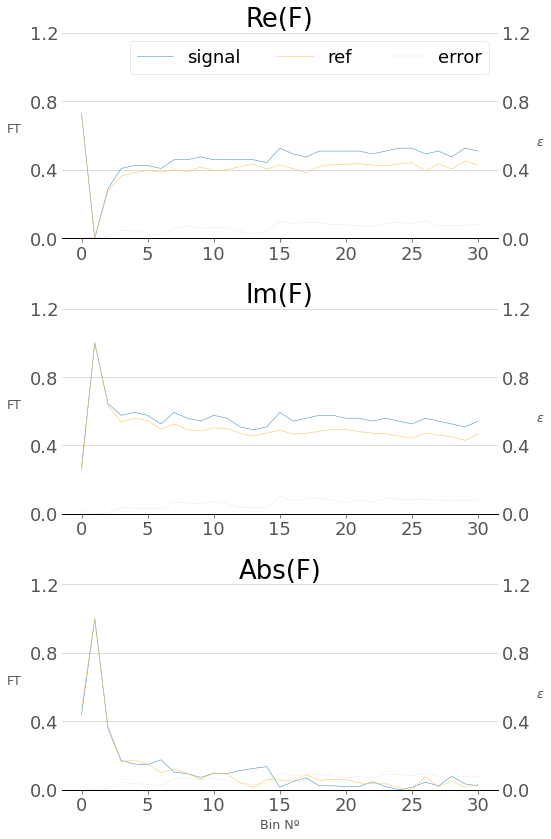

In [1]:
#!/usr/bin/env python3
"""
Script for testing the SNNNumpy class with sample data
"""
# Standard libraries
import matplotlib.pyplot as plt
import numpy as np
import pathlib
# Local libraries
import spikingFT.startup
import spikingFT.utils.plotter
import spikingFT.utils.metrics


def get_ft_components(nsamples, data):
    """
    Return the real imaginary, and modulus of the np.fft of input data
    """
    ft_np = np.fft.fft(data[0, :])
    ft_np_comps = np.vstack((ft_np.real, ft_np.imag)).transpose()
    ft_np_norm = spikingFT.utils.metrics.simplify_ft(ft_np_comps)
    ft_real = ft_np_norm[:, 0]
    ft_imag = ft_np_norm[:, 1]
    ft_modulus = np.abs(ft_np)[1:int(nsamples/2)]
    ft_modulus -= ft_modulus.min()
    ft_modulus /= ft_modulus.max()
    return (ft_real, ft_imag, ft_modulus)





filename="../config/experiment_special_cases.json"           
sim_handler = spikingFT.startup.startup(filename, autorun=False)        
n_chirps = sim_handler.config["data"]["chirps_per_frame"]        
platform = sim_handler.config["snn_config"]["framework"]        
mode = sim_handler.config["snn_config"]["mode"]        
      
folder_path = "./{}_{}_results/".format(mode, platform)        
pathlib.Path(folder_path).mkdir(parents=True, exist_ok=True)        
for chirp_n in range(1):        
    sim_handler.run(chirp_n)        
    nsamples = sim_handler.snn.nsamples        
    sim_time = sim_handler.config["snn_config"]["sim_time"]        
    spikes = sim_handler.snn.spikes        
    voltage = sim_handler.snn.voltage        
    rel_error = sim_handler.metrics["rel_error"]        
    spikes = spikingFT.utils.metrics.simplify_ft(spikes[:, :, -1])        
        
    real_spikes = sim_handler.output[:, 0][1:int(nsamples/2)]        
    imag_spikes = sim_handler.output[:, 1][1:int(nsamples/2)]        
    simplified_output = spikingFT.utils.metrics.simplify_ft(sim_handler.output)
    sft_real = simplified_output[:, 0]        
    sft_imag = simplified_output[:, 1]        
    sft_modulus = np.sqrt(real_spikes**2 + imag_spikes**2)        
    sft_modulus -= sft_modulus.min()        
    sft_modulus /= sft_modulus.max()        
    ft_real, ft_imag, ft_modulus = get_ft_components(nsamples, sim_handler.data)        
    
    real_error = rel_error[:, 0]        
    imag_error = rel_error[:, 1]        
    abs_error = (real_error + imag_error) / 2        
    kwargs = {}        
    kwargs["plot_names"] = ["real_spectrum", "imag_spectrum", "modulus"]        
    kwargs["data"] = [        
        (sft_real, ft_real, real_error),        
        (sft_imag, ft_imag, imag_error),        
       (sft_modulus, ft_modulus, abs_error)        
    ]        
    error_plotter = spikingFT.utils.plotter.RelErrorPlotter(**kwargs)        
    fig = error_plotter()        
        
    plt.show()


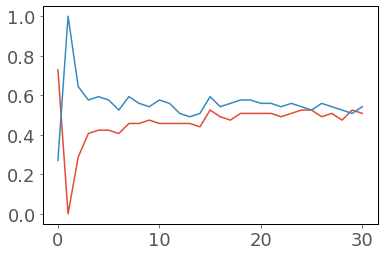

In [2]:
plt.plot(sft_real)
plt.plot(sft_imag)
plt.show()

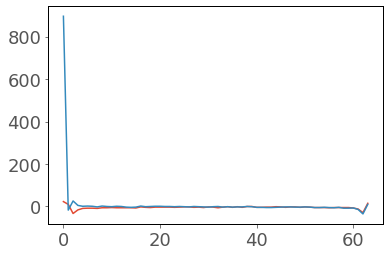

In [3]:
plt.plot(sim_handler.output)
plt.show()

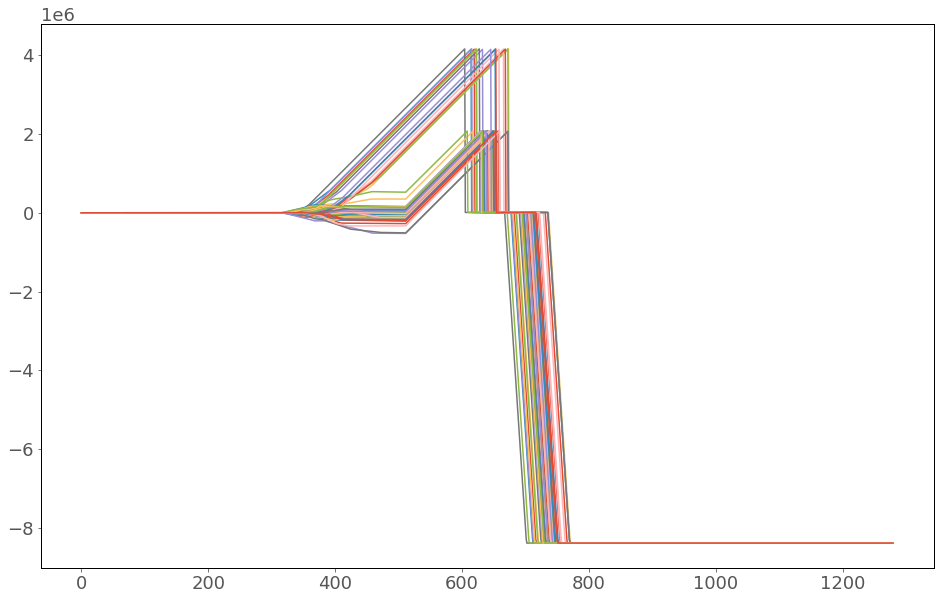

In [4]:
plt.figure(figsize=(16,10))
plt.plot(sim_handler.snn.voltage[:,:,0,1])
plt.show()